##### Copyright 2020 The TensorFlow Hub Authors.


In [34]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 937777597805354700
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3640655872
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3170171276696992397
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [35]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/classify_text_with_bert"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/bert/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

# Classify text with BERT

This tutorial contains complete code to fine-tune BERT to perform sentiment analysis on a dataset of plain-text IMDB movie reviews.
In addition to training a model, you will learn how to preprocess text into an appropriate format.

In this notebook, you will:

- Load the IMDB dataset
- Load a BERT model from TensorFlow Hub
- Build your own model by combining BERT with a classifier
- Train your own model, fine-tuning BERT as part of that
- Save your model and use it to classify sentences

If you're new to working with the IMDB dataset, please see [Basic text classification](https://www.tensorflow.org/tutorials/keras/text_classification) for more details.

## About BERT

[BERT](https://arxiv.org/abs/1810.04805) and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models. The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers. 

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.


## Setup


In [36]:
# A dependency of the preprocessing for BERT inputs
!pip install -U "tensorflow-text==2.13.*"

ERROR: Could not find a version that satisfies the requirement tensorflow-text==2.13.* (from versions: 2.4.0rc0, 2.4.0rc1, 2.4.1, 2.4.2, 2.4.3, 2.5.0rc0, 2.5.0, 2.6.0rc0, 2.6.0, 2.7.0rc0, 2.7.0rc1, 2.7.3, 2.8.0rc0, 2.8.1, 2.8.2, 2.9.0rc0, 2.9.0rc1, 2.9.0, 2.10.0b2, 2.10.0rc0, 2.10.0)
ERROR: No matching distribution found for tensorflow-text==2.13.*


You will use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [37]:
!pip install "tf-models-official==2.13.*"

  Using cached tf_models_official-2.13.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached PyYAML-6.0.1-cp38-cp38-win_amd64.whl.metadata (2.1 kB)
INFO: pip is looking at multiple versions of tf-models-official to determine which version is compatible with other requirements. This could take a while.
  Using cached tf_models_official-2.13.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached PyYAML-5.3.1-cp38-cp38-win_amd64.whl.metadata (1.7 kB)
  Using cached tf_models_official-2.13.0-py2.py3-none-any.whl.metadata (1.4 kB)

The conflict is caused by:
    tf-models-official 2.13.2 depends on tensorflow-text~=2.13.0
    tf-models-official 2.13.1 depends on tensorflow-text~=2.13.0
    tf-models-official 2.13.0 depends on tensorflow-text~=2.13.0

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip attempt to solve the dependency conflict



ERROR: Cannot install tf-models-official==2.13.0, tf-models-official==2.13.1 and tf-models-official==2.13.2 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


In [38]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

## Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/).

### Download the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.


In [39]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

A continuación, se utilizará el text_dataset_from_directory utilidad para crear una etiqueta tf.data.Dataset .

El conjunto de datos de IMDB ya se ha dividido en entrenamiento y prueba, pero carece de un conjunto de validación. Vamos a crear un conjunto de validación utilizando una mezcla al 80/20 escisión de la formación de datos mediante el uso de la validation_split argumento a continuación.

Nota: Al utilizar los validation_split y subset argumentos, asegúrese de especificar una semilla aleatoria, o para pasar shuffle=False , por lo que las divisiones de validación y de formación tienen ninguna superposición.

In [40]:
AUTOTUNE = tf.data.AUTOTUNE#PERITE MEJORAR EL PROCESAMIENTO DE LOS DATOS ENTRE CPU Y GPU
batch_size = 32
seed = 42

brut_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

classes = brut_train_ds.class_names
train_ds = brut_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


Echemos un vistazo a algunas reseñas.



In [41]:
for text_batch, label_batch in train_ds.take(2):#tima una muestra de texto y etiquetas del train tomando el 1 lote
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({classes[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

## Carga de modelos desde TensorFlow Hub
Aquí puede elegir qué modelo BERT cargará desde TensorFlow Hub y ajustarlo. Hay varios modelos BERT disponibles.

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) con pesos capacitados dadas a conocer por los autores originales de BERT.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1)  tienen la misma arquitectura general pero menos y / o bloques de transformadores pequeños, lo que le permite explorar soluciones de compromiso entre velocidad, el tamaño y la calidad.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): cuatro tamaños diferentes de "A Lite BERT" que reduce el tamaño del modelo (pero no el tiempo de cálculo) mediante el intercambio de parámetros entre las capas.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): ocho modelos que todos tienen la arquitectura BERT-base, pero ofrecen una elección entre diferentes dominios pre-formación, para alinear más estrechamente con la tarea de destino.
  - [Electra](https://tfhub.dev/google/collections/electra/1) tiene la misma arquitectura que el BERT (en tres tamaños diferentes), pero se pre-formó como un discriminador en una puesta a punto que se asemeja a una red Acusatorio generativo (GAN).
  - BERT con hablar-Heads Atención y cerrada GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] tiene dos mejoras en el núcleo de la arquitectura del transformador.

La documentación del modelo en TensorFlow Hub tiene más detalles y referencias a la literatura de investigación. Siga los enlaces de arriba o haga clic en el [`tfhub.dev`](http://tfhub.dev) URL impresa después de la siguiente ejecución celular.

La sugerencia es comenzar con un Small BERT (con menos parámetros) ya que son más rápidos de ajustar. Si le gusta un modelo pequeño pero con mayor precisión, ALBERT podría ser su próxima opción. Si desea una precisión aún mayor, elija uno de los tamaños clásicos de BERT o sus mejoras recientes como Electra, Talking Heads o BERT Expert.

Aparte de los modelos disponibles a continuación, existen [multiple versions](https://tfhub.dev/google/collections/transformer_encoders_text/1) de los modelos que son más grandes y pueden producir incluso una mayor precisión, pero son demasiado grandes para ser puesto a punto en una sola GPU. Usted será capaz de hacer eso en las  [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).

Verá en el código a continuación que cambiar la URL tfhub.dev es suficiente para probar cualquiera de estos modelos, porque todas las diferencias entre ellos están encapsuladas en SavedModels de TF Hub.

In [42]:
#@title Choose a BERT model to fine-tune

model_bert_small = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

dict_name_elementos = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

dict_model_preprocesamiento = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_encoder = dict_name_elementos[model_bert_small]
tfhub_preprocess = dict_model_preprocesamiento[model_bert_small]

print(f'modelo BERT seleccionado          : {tfhub_encoder}')
print(f'modelo de procesamiento auto-select: {tfhub_preprocess}')

modelo BERT seleccionado          : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
modelo de procesamiento auto-select: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## The preprocessing model

Las entradas de texto deben transformarse en identificadores de token numéricos y organizarse en varios tensores antes de ingresar a BERT. TensorFlow Hub proporciona un modelo de preprocesamiento coincidente para cada uno de los modelos BERT discutidos anteriormente, que implementa esta transformación mediante operaciones TF de la biblioteca TF.text. No es necesario ejecutar código Python puro fuera de su modelo de TensorFlow para preprocesar el texto.

El modelo de preprocesamiento debe ser el referenciado por la documentación del modelo BERT, que puede leer en la URL impresa arriba. Para los modelos BERT del menú desplegable anterior, el modelo de preprocesamiento se selecciona automáticamente.

Nota: Va a cargar el modelo de pre-procesamiento en un[hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer)  para componer su modelo afinado. Esta es la API preferida para cargar un modelo guardado de estilo TF2 desde TF Hub en un modelo de Keras.

In [43]:
bert_model = hub.KerasLayer(tfhub_preprocess)

Probemos el modelo de preprocesamiento en algún texto y veamos el resultado:

In [44]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


Como se puede ver, ahora tienes las 3 salidas del procesamiento previo que un modelo BERT usaría ( input_words_id , input_mask y input_type_ids ).

Algunos otros puntos importantes:

La entrada se trunca a 128 tokens. El número de fichas se pueden personalizar, y se puede ver más detalles sobre las [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).
- Los input_type_ids sólo tienen un valor (0) porque se trata de una sola entrada de frase. Para una entrada de oración múltiple, tendría un número para cada entrada.

Since this text preprocessor is a TensorFlow model, It can be included in your model directly.

## Using the BERT model

Before putting BERT into your own model, let's take a look at its outputs. You will load it from TF Hub and see the returned values.

In [45]:
bert_model = hub.KerasLayer(tfhub_encoder)

In [46]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.7627077   0.99281555 -0.18582706  0.36662924  0.1522526   0.6546847
  0.9680785  -0.9486284   0.00222114 -0.9877621   0.06816285 -0.97633356]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28963175  0.34405506  0.33247155 ...  0.21314469  0.7099184
  -0.05761933]
 [-0.28767946  0.32039538 -0.2300917  ...  0.58436346 -0.21390796
   0.72653276]
 [-0.6615503   0.68963593 -0.8745534  ...  0.10876748 -0.26226947
   0.4786108 ]
 ...
 [-0.22565717 -0.2883794  -0.07101713 ...  0.47547257  0.83277035
   0.39971223]
 [-0.29769775 -0.2741809  -0.05516911 ...  0.48888117  1.0950792
   0.18138665]
 [-0.44337055  0.00987268  0.07228002 ...  0.17261039  1.1834637
   0.07838699]]


.    Los modelos BERT devuelven un mapa con 3 claves importantes: pooled_output , sequence_output , encoder_outputs :

- pooled_output representa cada secuencia de entrada como un todo. La forma es [batch_size, H] . Puede pensar en esto como una incrustación para toda la revisión de la película.
- sequence_output representa cada entrada de ficha en el contexto. La forma es [batch_size, seq_length, H] . Puede pensar en esto como una inserción contextual para cada token en la reseña de la película.
- encoder_outputs son las activaciones de los intermedios L Transformador bloques. outputs["encoder_outputs"][i] es un tensor de la forma [batch_size, seq_length, 1024] con las salidas del i-ésimo bloque transformador, para 0 <= i < L . El último valor de la lista es igual a sequence_output .<br>
Para la puesta a punto que se va a utilizar el pooled_output matriz.

## Define tu modelo
Creará un modelo ajustado muy simple, con el modelo de preprocesamiento, el modelo BERT seleccionado, una capa densa y una de abandono.

Nota: para obtener más información sobre la entrada y salida del modelo base se puede seguir la dirección URL del modelo para la documentación. Aquí específicamente, no necesita preocuparse porque el modelo de preprocesamiento se encargará de eso por usted.


In [47]:
def modelo_clasificador_bert():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')#se crea la capa de entrada
  preprocessing_layer = hub.KerasLayer(tfhub_preprocess, name='preprocessing') #se carga el modelo de preprocesamiento
  encoder_inputs = preprocessing_layer(text_input)#se pasa el texto por el preprocesamiento
  encoder = hub.KerasLayer(tfhub_encoder, trainable=True, name='BERT_encoder')#se carga el modelo BERT con la capa congelada
  outputs = encoder(encoder_inputs)#se pasa el texto por el encoder
  net = outputs['pooled_output']#se toma la salida de la capa de pooling
  net = tf.keras.layers.Dropout(0.1)(net)#se aplica dropout
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)#se aplica una capa densa con una neurona
  return tf.keras.Model(text_input, net)  #se crea el modelo

Comprobemos que el modelo se ejecuta con la salida del modelo de preprocesamiento.

In [48]:
modelo_clasificador = modelo_clasificador_bert()#se crea el modelo
bert_raw_result = modelo_clasificador(tf.constant(text_test))#tf.constant convierte el texto en tensor y se pasa una muestra de texto por el modelo y 
print(tf.sigmoid(bert_raw_result))#se aplica la función de activación sigmoide para obtener la probabilidad

tf.Tensor([[0.5150879]], shape=(1, 1), dtype=float32)


El resultado no tiene sentido, por supuesto, porque el modelo aún no se ha entrenado.

Echemos un vistazo a la estructura del modelo.

In [49]:
import graphviz
import pydot


In [54]:
tf.keras.utils.plot_model(modelo_clasificador)#se muestra la arquitectura del modelo

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Entrenamiento de modelos

Ahora tiene todas las piezas para entrenar un modelo, incluido el módulo de preprocesamiento, el codificador BERT, los datos y el clasificador.



## Función de pérdida

Dado que este es un problema de clasificación binaria y el modelo de salida a una probabilidad (una capa de una sola unidad), que va a utilizar losses.BinaryCrossentropy función de pérdida.


In [55]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)#from_logits=True se usa cuando la salida de la red no tiene función de activación
metrics = tf.metrics.BinaryAccuracy()

### Optimizador

Para un ajuste fino, usemos el mismo optimizador con el que se entrenó originalmente BERT: los "Momentos adaptativos" (Adam). Este optimizador minimiza la pérdida de predicción y hace regularización por caries peso (sin uso de momentos), que también se conoce como[AdamW](https://arxiv.org/abs/1711.05101).

Para la tasa de aprendizaje ( init_lr ), que va a utilizar el mismo horario que el BERT-capacitación previa: la descomposición lineal de una tasa inicial de aprendizaje teórico, con el prefijo con una fase lineal de calentamiento durante el primer 10% de la formación de los pasos ( num_warmup_steps ). De acuerdo con el documento BERT, la tasa de aprendizaje inicial es menor para el ajuste fino (mejor de 5e-5, 3e-5, 2e-5).

In [56]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()#experimental.cardinality devuelve el número de elementos de un dataset
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)#se calculan los pasos de calentamiento

init_lr = 3e-5#se define la tasa de aprendizaje
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Carga del modelo BERT y formación

Utilizando el classifier_model creó anteriormente, puede compilar el modelo con la pérdida, métrica y un optimizador.

In [57]:
modelo_clasificador.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Nota: tiempo entrenando variará dependiendo de la complejidad del modelo BERT que haya seleccionado.

In [58]:
print(f'entrenamiento con {tfhub_encoder}')
history =modelo_clasificador.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

entrenamiento con https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5


625/625 [==============================] - 164s 253ms/step - loss: 0.4950 - binary_accuracy: 0.7329 - val_loss: 0.3872 - val_binary_accuracy: 0.8336
Epoch 2/5
625/625 [==============================] - 158s 253ms/step - loss: 0.3319 - binary_accuracy: 0.8499 - val_loss: 0.3693 - val_binary_accuracy: 0.8446
Epoch 3/5
625/625 [==============================] - 162s 259ms/step - loss: 0.2545 - binary_accuracy: 0.8942 - val_loss: 0.3963 - val_binary_accuracy: 0.8448
Epoch 4/5
625/625 [==============================] - 166s 266ms/step - loss: 0.1953 - binary_accuracy: 0.9237 - val_loss: 0.4386 - val_binary_accuracy: 0.8530
Epoch 5/5
625/625 [==============================] - 164s 262ms/step - loss: 0.1550 - binary_accuracy: 0.9420 - val_loss: 0.4838 - val_binary_accuracy: 0.8486


### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [59]:
loss, accuracy = modelo_clasificador.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 107s 137ms/step - loss: 0.4562 - binary_accuracy: 0.8548
Loss: 0.456239253282547
Accuracy: 0.8547599911689758


### Trace la precisión y la pérdida a lo largo del tiempo
Basado en la History objeto devuelto por model.fit() . Puede trazar la pérdida de entrenamiento y validación para comparar, así como la precisión de entrenamiento y validación:

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


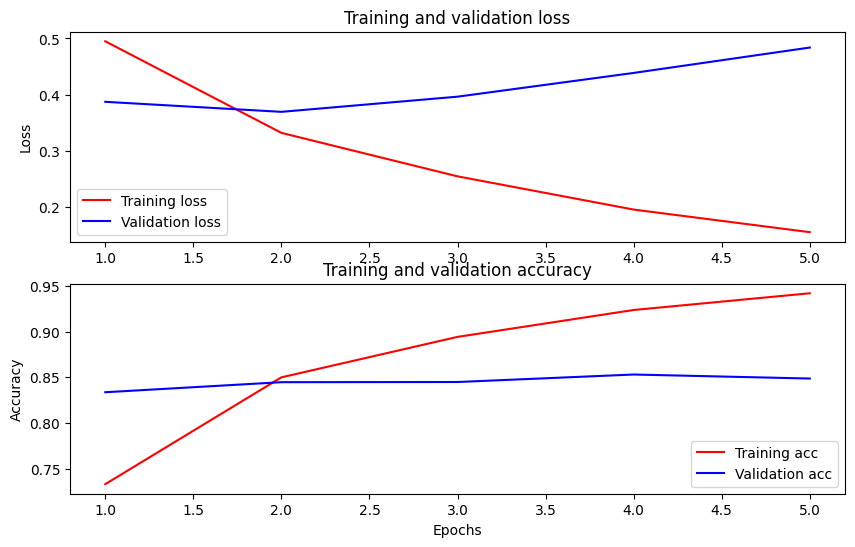

In [60]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

En este gráfico, las líneas rojas representan la pérdida y la precisión del entrenamiento, y las líneas azules son la pérdida y la precisión de la validación.

## Exportar para inferencia
Ahora, simplemente guarde su modelo ajustado para usarlo más adelante.

In [65]:
import h5py

In [66]:
dataset_name = 'imdb_bert_small'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))


modelo_clasificador.save(saved_model_path, include_optimizer=False)

AttributeError: module 'h5py' has no attribute 'File'

Recarguemos el modelo, para que puedas probarlo junto con el modelo que aún está en la memoria.

In [23]:
reloaded_model = tf.saved_model.load(saved_model_path)

Aquí puede probar su modelo en cualquier oración que desee, solo agregue a la variable de ejemplos a continuación.

In [24]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.997565
input: The movie was great!           : score: 0.983252
input: The movie was meh.             : score: 0.986901
input: The movie was okish.           : score: 0.206568
input: The movie was terrible...      : score: 0.001724

Results from the model in memory:
input: this is such an amazing movie! : score: 0.997565
input: The movie was great!           : score: 0.983252
input: The movie was meh.             : score: 0.986901
input: The movie was okish.           : score: 0.206568
input: The movie was terrible...      : score: 0.001724



Si desea utilizar su modelo en [TF Serving](https://www.tensorflow.org/tfx/guide/serving), recuerde que va a llamar a su SavedModel través de una de sus firmas con nombre. En Python, puede probarlos de la siguiente manera:

In [25]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: this is such an amazing movie! : score: 0.997565
input: The movie was great!           : score: 0.983252
input: The movie was meh.             : score: 0.986901
input: The movie was okish.           : score: 0.206568
input: The movie was terrible...      : score: 0.001724



## Next steps

As a next step, you can try [Solve GLUE tasks using BERT on a TPU tutorial](https://www.tensorflow.org/text/tutorials/bert_glue), which runs on a TPU and shows you how to work with multiple inputs.